In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [0]:
df_train = pd.read_csv('train_data.tsv.gz', sep='\t')
df_test =  pd.read_csv('test_data.tsv.gz', sep='\t')

In [3]:
df_train.head()

,id,city,price,brand,model,drive_type,engine_summary,owner_type,generation,year,color,body,gear_type,wheel_type,state,is_new,doors_count,mileage,owners_by_pts
0,9cbd65bfd61bc7405d6866a5,Советск,40000.0,ВАЗ (Lada),2105,Задний,1.5 л / 71 л.с. / Бензиновый,Частники,1 поколение,1999,Фиолетовый,Седан,Механика,Левый,Хорошее,Нет,5.0,178000.0,3.0
1,5d6fa4d552284029123966a5,Москва,105000.0,ВАЗ (Lada),2114,Передний,1.5 л / 77 л.с. / Бензиновый,Частники,1 поколение,2006,Голубой,Хетчбэк,Механика,Левый,Хорошее,Нет,5.0,200000.0,2.0
2,52fd95e853654e3c4d7966a5,Александров,650000.0,Cadillac,SRX,Полный,3.6 л / 258 л.с. / Бензиновый,Частники,1 поколение,2008,Синий,Кроссовер,Автомат,Левый,Не битый,Нет,5.0,185000.0,3.0
3,beb7c749571bc740820038a5,Новокуйбышевск,400000.0,Chevrolet,Lacetti,Передний,1.6 л / 109 л.с. / Бензиновый,Частники,1 поколение,2013,Красный,Седан,Механика,Левый,Не битый,Нет,4.0,59000.0,1.0
4,34d7824a60964435b93c68a5,Москва,1000000.0,Jeep,Commander,Полный,3 л / 218 л.с. / Дизельный,Частники,1 поколение,2008,Черный,Внедорожник,Автомат,Левый,Не битый,Нет,5.0,200000.0,2.0


In [5]:
df_train.describe()

,price,year,doors_count,mileage,owners_by_pts
count,8.995900e+04,89959.000000,89634.000000,85061.000000,82519.000000
mean,4.623758e+05,2006.563157,4.413972,153381.828241,2.729359
std,8.303380e+05,7.919322,0.625520,95010.272973,1.248285
min,1.500000e+04,1950.000000,-1.000000,1.000000,1.000000
25%,1.000000e+05,2002.000000,4.000000,92000.000000,2.000000
50%,2.500000e+05,2007.000000,4.000000,140000.000000,3.000000
75%,4.900000e+05,2012.000000,5.000000,200000.000000,4.000000
max,3.000000e+07,2019.000000,5.000000,999999.000000,12.000000


Target

(0.0, 10000000.0)

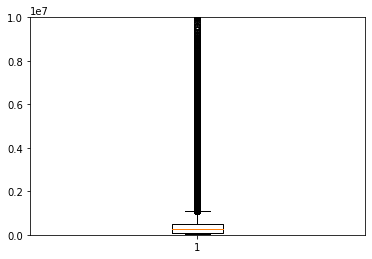

In [6]:
plt.boxplot(df_train.price)
plt.ylim(0,10**7)

{'boxes': [<matplotlib.lines.Line2D at 0x7fee4c3e65f8>],
 'caps': [<matplotlib.lines.Line2D at 0x7fee4c3f1048>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fee4c3f1ac8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7fee4c3f1748>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7fee4c3e6908>,
  <matplotlib.lines.Line2D at 0x7fee4c3e6c88>]}

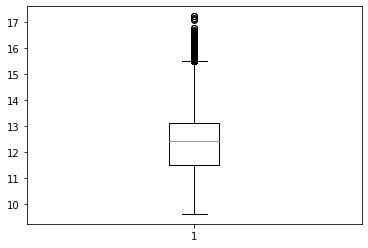

In [7]:
plt.boxplot(df_train.price.apply(np.log))

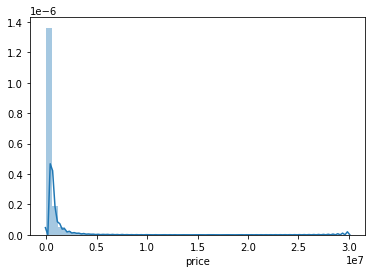

In [8]:
sns.distplot(df_train['price'])
plt.show()

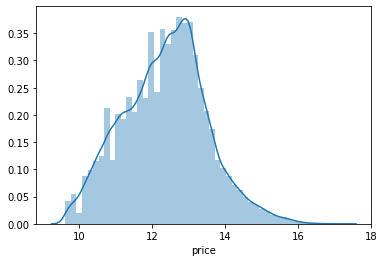

In [9]:
sns.distplot(np.log(df_train['price']+1))
plt.show()

Features

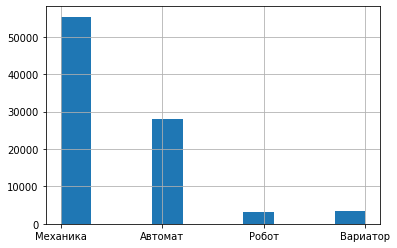

In [10]:
df_train['gear_type'].hist()

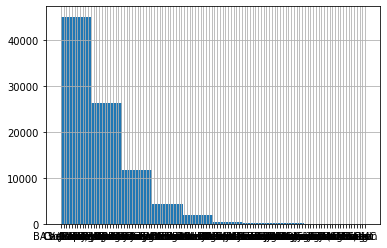

In [11]:
df_train['brand'].hist()

In [12]:
df_train['brand'].value_counts()

ВАЗ (Lada)    24936
Toyota         5978
Hyundai        4614
Kia            4483
Nissan         4174
              ...  
Landwind          1
Wartburg          1
Maserati          1
HuangHai          1
Doninvest         1
Name: brand, Length: 112, dtype: int64

<Figure size 1440x720 with 0 Axes>

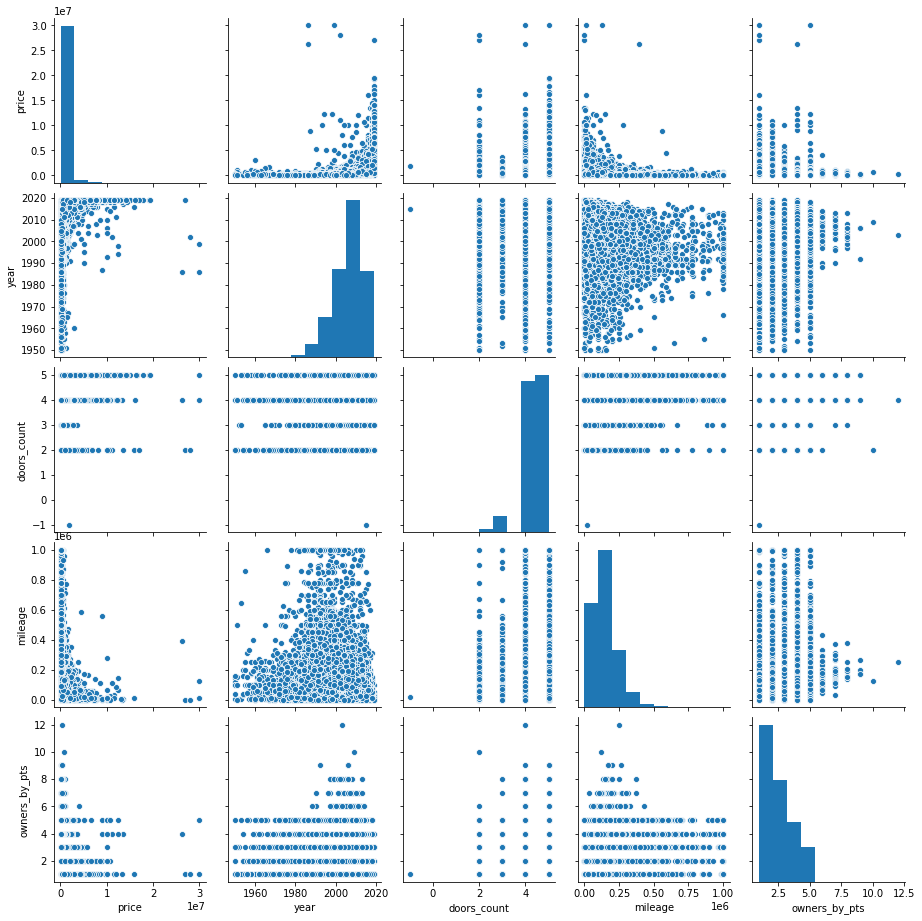

In [13]:
numeric = df_train.select_dtypes(include=['float', 'int'])
plt.figure(figsize=(20, 10))
sns.pairplot(numeric)

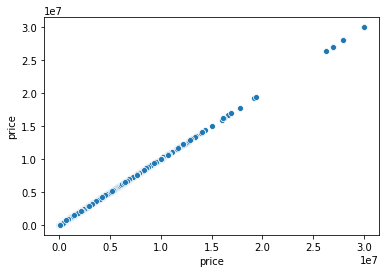

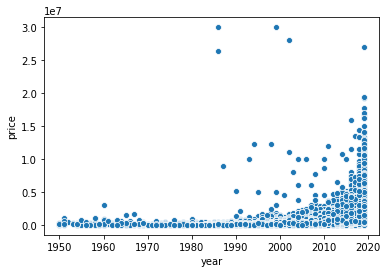

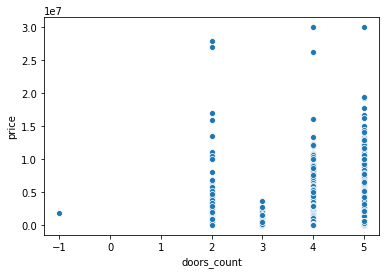

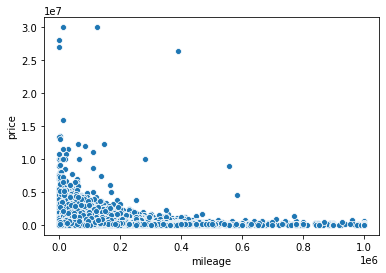

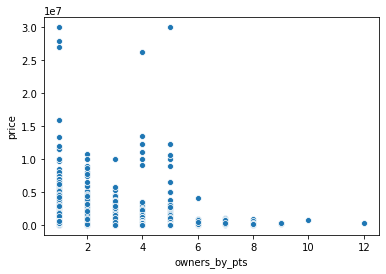

In [14]:
for i, col in enumerate (numeric.columns):
    plt.figure(i)
    sns.scatterplot(x=numeric[col],y=numeric['price'])

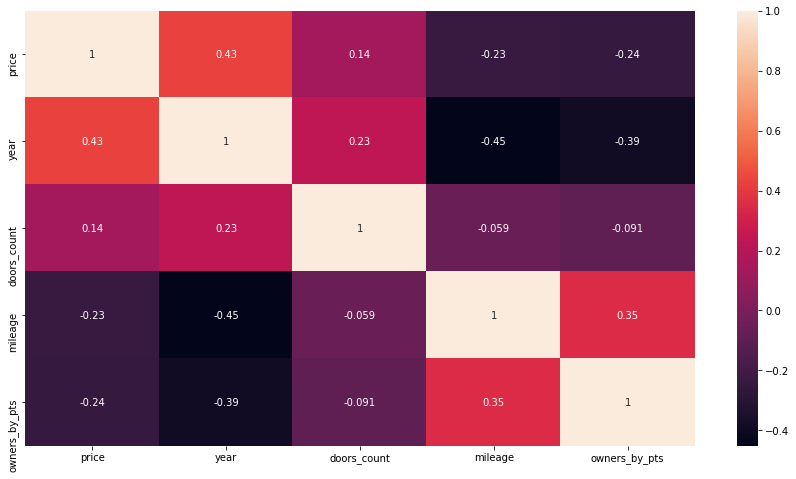

In [15]:
corr=numeric.corr()

plt.figure(figsize=(15,8))
sns.heatmap(corr,annot=True)

In [16]:
df_train.isna().any()

id                False
city              False
price             False
brand             False
model              True
drive_type         True
engine_summary     True
owner_type        False
generation         True
year              False
color              True
body               True
gear_type          True
wheel_type         True
state              True
is_new            False
doors_count        True
mileage            True
owners_by_pts      True
dtype: bool

Processing

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, StratifiedKFold


def pipe(df_train, df_test, num_cols, cat_cols):

  df_train.engine_summary = df_train.engine_summary.str.split(' ').str[-1]
  df_test.engine_summary = df_test.engine_summary.str.split(' ').str[-1]

  # split 
  X_train = df_train.loc[:, map(lambda x :x not in ['price', 'id'], list(df_train.columns))].values #df_train.loc[:, ['mileage', 'brand']].values
  y_train = df_train.loc[:, 'price'].values

  X_test = df_test.loc[:, map(lambda x :x not in ['price', 'id'], list(df_test.columns))].values #df_test.loc[:, ['mileage', 'brand']].values

  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

  categ_preprocess = \
  Pipeline([
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('ohe', OneHotEncoder(handle_unknown='ignore'))    
  ])
  
  numeric_preprocess = \
  Pipeline([
      ('impute', SimpleImputer(strategy='median')),
      ('scaler', StandardScaler())
  ])
  
  col_transformer = ColumnTransformer([
      ('categorical', categ_preprocess, cat_cols),
      ('numeric', numeric_preprocess, num_cols),
  ])

  trans = \
  Pipeline([
      ('preprocess', col_transformer)
  
  ])

  processed_train = trans.fit_transform(X_train)
  processed_val = trans.transform(X_val)
  processed_test = trans.transform(X_test)

  return processed_train, y_train, processed_val, y_val, processed_test



In [0]:
categ = [0, 1, 2,3, 4, 5, 6, 8,9, 10,11, 12, 13] 
numeric = [7, 14, 15, 16]

X_train, y_train, X_val, y_val, X_test = pipe(df_train, df_test, numeric, categ)

Loss function

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Ridge regression

In [28]:
param_grid = \
{'alpha': np.logspace(-3, 3, 100)}
model = Ridge()
cv = KFold(n_splits=5, shuffle=True, random_state=123)
searcher = \
RandomizedSearchCV(model, param_grid, n_iter=20, cv=cv, 
                   scoring='neg_mean_squared_error',
                   n_jobs=5, refit=True, verbose=2, 
                   random_state=123)

searcher.fit(X_train, np.log(y_train+1))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   26.0s finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   error_score=nan,
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='deprecated', n_iter=20, n_jobs=5,
                   param_distributions={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1....
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
                   pre_dispatch='2*n_jobs', random_state=123, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error'

In [31]:
y_pred = np.exp(searcher.best_estimator_.predict(X_val))-1
mean_absolute_percentage_error(y_val, y_pred)

25.70692511836228

In [0]:
y_test_pred1 = np.exp(searcher.best_estimator_.predict(X_test))-1

Xgboost

In [0]:
import xgboost as xgb

In [0]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [15, 20, 25, 30],
        'learning_rate':[0.01, 0.02, 0.03, 0.04,0.05,0.06,0.07,0.08, 0.1]
        }

reg = xgb.XGBRegressor(n_estimators=1000, objective='reg:linear',
                    silent=True, nthread=1)



In [38]:
%%time
folds = 3
param_comb = 10

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 100)

random_s = RandomizedSearchCV(reg, param_distributions=params, n_iter=param_comb, scoring='neg_mean_absolute_error', n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

random_s.fit(X_train, np.log(y_train+1))


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 40.2min finished


CPU times: user 2min 19s, sys: 276 ms, total: 2min 20s
Wall time: 42min 31s


In [40]:
y_pred = np.exp(random_s.best_estimator_.predict(X_val))-1
mean_absolute_percentage_error(y_val, y_pred)

24.27800457617029

In [0]:
y_test_pred2 = np.exp(random_s.best_estimator_.predict(X_test))-1

In [0]:
submission = df_test.loc[:, ['id']]
submission.loc[:, 'price'] = y_test_pred2
submission.to_csv('submission_cars.csv', index=False)

Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    


In [46]:
parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'n_estimators' : sp_randInt(300, 1000),
              'max_depth'    : sp_randInt(4, 13) 
                 }

model = GradientBoostingRegressor()

randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, 
                               cv = 3, n_iter = 10, n_jobs=-1)
randm.fit(X_train, np.log(y_train + 1))


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                       criterion='friedman_mse',
                                                       init=None,
                                                       learning_rate=0.1,
                                                       loss='ls', max_depth=3,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                             

In [47]:
y_pred = np.exp(randm.best_estimator_.predict(X_val)) -1
mean_absolute_percentage_error(y_val, y_pred)

24.88095910711493

In [0]:
y_test_pred3 = np.exp(randm.best_estimator_.predict(X_test)) -1

Ensembling

In [0]:
y_test_pred_b = (y_test_pred1 + y_test_pred2 + y_test_pred3)/3
submission = df_test.loc[:, ['id']]
submission.loc[:, 'price'] = y_test_pred_b
submission.to_csv('submission_cars3.csv', index=False)